In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing

In [8]:
df = pd.read_csv(".././data/original/base_hcpc_final.csv", sep=";")
df.dtypes

N_sans_P                   float64
final_capillarite_agg       object
final_hyperplasie_pn        object
final_pn_alv                object
final_fibrin_alv            object
final_mPNPorg               object
final_infiltrat_B_BNSP      object
final_infiltrat_A_A1_A2     object
clust                        int64
protocol_cause              object
NEFG2                       object
delai_prelevement            int64
time_point                  object
date_prelevement            object
LT_date                     object
final_infiltrat_A           object
final_infiltrat_B           object
final_C4d                    int64
final_C4d_distrib          float64
final_C4d_int              float64
dtype: object

In [9]:
# 2. Création d'un DataFrame ne contenant que les colonnes de type 'object' (texte)
df_object_only = df[df.select_dtypes(include=["object"]).columns]

# 3. Définition des colonnes à modifier
cols_to_change = [
    "final_capillarite_agg",
    "final_hyperplasie_pn",
    "final_pn_alv",
    "final_fibrin_alv",
    "final_mPNPorg",
    "final_infiltrat_B_BNSP",
    "final_infiltrat_A_A1_A2",
]

# 4. Extraction du dernier caractère de chaque valeur dans les colonnes sélectionnées
df.loc[:, cols_to_change] = df[cols_to_change].apply(lambda x: x.str[-1])

# 5. Conversion des colonnes en type int8
df[cols_to_change] = df[cols_to_change].astype("int8")

{col: df[col].unique() for col in cols_to_change}

{'final_capillarite_agg': array([0, 1], dtype=int8),
 'final_hyperplasie_pn': array([0, 1], dtype=int8),
 'final_pn_alv': array([0, 1], dtype=int8),
 'final_fibrin_alv': array([0, 1], dtype=int8),
 'final_mPNPorg': array([0, 1], dtype=int8),
 'final_infiltrat_B_BNSP': array([0, 1], dtype=int8),
 'final_infiltrat_A_A1_A2': array([1, 0], dtype=int8)}

In [10]:
# Liste des colonnes à transformer
cols_to_change = ["final_infiltrat_A", "final_infiltrat_B"]

# Dictionnaire de mapping pour la colonne final_infiltrat_A
# Convertit les valeurs A0, A1, A2 en valeurs numériques 0, 1, 2
mapping_A = {
    "A0": "0",  # A0 devient 0
    "A1": "1",  # A1 devient 1
    "A2": "2",  # A2 devient 2
}

# Dictionnaire de mapping pour la colonne final_infiltrat_B
# Convertit les valeurs B0, B1, BNSP en valeurs numériques 0, 1, 2
mapping_B = {
    "B0": "0",  # B0 devient 0
    "B1": "1",  # B1 devient 1
    "BNSP": "2",  # BNSP devient 2
}

# Application des mappings aux colonnes
df.loc[:, "final_infiltrat_A"] = df["final_infiltrat_A"].map(mapping_A)
df.loc[:, "final_infiltrat_B"] = df["final_infiltrat_B"].map(mapping_B)

# Vérification des valeurs uniques dans chaque colonne après transformation
{col: df[col].unique() for col in cols_to_change}

{'final_infiltrat_A': array(['1', '0', '2'], dtype=object),
 'final_infiltrat_B': array(['0', '2', '1'], dtype=object)}

In [11]:
# Conversion des jours en mois (en arrondissant au mois le plus proche)
df["time_point_std"] = round(
    df["delai_prelevement"] / 30.44
)  # 30.44 jours par mois en moyenne


# Si vous préférez une version plus stricte avec des intervalles définis
def jours_vers_timepoint(jours):
    if pd.isna(jours):
        return np.nan

    # Définition des intervalles en jours
    if jours <= 45:  # M1
        return 1
    elif jours <= 75:  # M2
        return 2
    elif jours <= 105:  # M3
        return 3
    elif jours <= 135:  # M4
        return 4
    elif jours <= 165:  # M5
        return 5
    elif jours <= 225:  # M6
        return 6
    elif jours <= 315:  # M9
        return 9
    elif jours <= 405:  # M12
        return 12
    else:  # >M12
        return 13


df["time_point_std"] = df["delai_prelevement"].apply(jours_vers_timepoint)

# Vérification
print("Nombre de patients par timepoint :")
print(df["time_point_std"].value_counts().sort_index())

Nombre de patients par timepoint :
time_point_std
1     314
2     314
3     323
4     297
5      45
6     293
9     269
12    282
13    382
Name: count, dtype: int64


# Data Engineering

In [12]:
def creer_caracteristiques_patient(df):
    resultats = []

    for patient, groupe in df.groupby("NEFG2"):
        features = {}
        features["NEFG2"] = patient

        # 1. Caractéristiques temporelles basiques
        features["nb_biopsies"] = len(groupe)
        features["delai_premiere_biopsie"] = groupe["delai_prelevement"].min()
        features["delai_derniere_biopsie"] = groupe["delai_prelevement"].max()
        features["duree_suivi"] = (
            features["delai_derniere_biopsie"] - features["delai_premiere_biopsie"]
        )

        # 2. Colonnes binaires
        colonnes_binaires = [
            "final_capillarite_agg",
            "final_hyperplasie_pn",
            "final_pn_alv",
            "final_fibrin_alv",
            "final_mPNPorg",
            "final_infiltrat_B_BNSP",
            "final_infiltrat_A_A1_A2",
        ]

        # 3. Création de caractéristiques temporelles pour chaque marqueur
        for col in colonnes_binaires:
            values = groupe[col].values
            times = groupe["delai_prelevement"].values

            # Statistiques de base
            features[f"{col}_mean"] = groupe[col].mean()
            features[f"{col}_ever_positive"] = (groupe[col] > 0).any()
            features[f"{col}_always_positive"] = (groupe[col] > 0).all()
            features[f"{col}_nb_changements"] = (
                groupe[col] != groupe[col].shift()
            ).sum() - 1

            # Nouvelles caractéristiques par marqueur
            features[f"{col}_prop_positive"] = (groupe[col] > 0).mean()
            features[f"{col}_early_positive"] = groupe[col].iloc[0] > 0
            features[f"{col}_late_positive"] = groupe[col].iloc[-1] > 0

            # Séquence de changements
            if len(groupe) > 1:
                features[f"{col}_sequence"] = "".join(groupe[col].astype(str))
                features[f"{col}_negative_to_positive"] = (
                    (groupe[col].shift() == 0) & (groupe[col] == 1)
                ).sum()
                features[f"{col}_positive_to_negative"] = (
                    (groupe[col].shift() == 1) & (groupe[col] == 0)
                ).sum()

                # Durée des épisodes positifs
                positive_episodes = (groupe[col] > 0).astype(int)
                features[f"{col}_mean_episode_duration"] = (
                    positive_episodes.mean() * features["duree_suivi"]
                )

        # 4. Score composite par biopsie
        groupe["nb_marqueurs_positifs"] = groupe[colonnes_binaires].sum(axis=1)
        features["mean_marqueurs_positifs"] = groupe["nb_marqueurs_positifs"].mean()
        features["max_marqueurs_positifs"] = groupe["nb_marqueurs_positifs"].max()
        features["min_marqueurs_positifs"] = groupe["nb_marqueurs_positifs"].min()

        # 5. Nouvelles caractéristiques temporelles
        if len(groupe) > 1:
            # Intervalles entre biopsies
            intervals = np.diff(sorted(groupe["delai_prelevement"]))
            features["mean_interval_biopsies"] = np.mean(intervals)
            features["std_interval_biopsies"] = np.std(intervals)
            features["max_interval_biopsies"] = np.max(intervals)
            features["min_interval_biopsies"] = np.min(intervals)

            # Caractéristiques de la trajectoire
            features["pic_marqueurs"] = groupe["nb_marqueurs_positifs"].idxmax()
            features["delai_pic"] = groupe.loc[
                features["pic_marqueurs"], "delai_prelevement"
            ]
            features["ratio_temps_pic"] = (
                features["delai_pic"] / features["duree_suivi"]
            )

        # 6. Patterns complexes
        # Cooccurrence des marqueurs
        for i, col1 in enumerate(colonnes_binaires):
            for j, col2 in enumerate(colonnes_binaires[i + 1 :], i + 1):
                cooc_name = f'cooc_{col1.split("_")[1]}_{col2.split("_")[1]}'
                features[cooc_name] = ((groupe[col1] == 1) & (groupe[col2] == 1)).mean()

        # 7. Caractéristiques de séquence
        if len(groupe) > 1:
            # Stabilité des marqueurs
            features["stabilite_globale"] = (
                1
                - (groupe[colonnes_binaires] != groupe[colonnes_binaires].shift())
                .mean()
                .mean()
            )

            # Vitesse de progression
            early_score = (
                groupe["nb_marqueurs_positifs"].iloc[: len(groupe) // 2].mean()
            )
            late_score = groupe["nb_marqueurs_positifs"].iloc[len(groupe) // 2 :].mean()
            features["progression_rate"] = (late_score - early_score) / (
                len(groupe) // 2
            )

        # 8. Patterns d'évolution
        features["pattern_evolution"] = "stable"
        if len(groupe) > 1:
            if features["progression_rate"] > 0.1:
                features["pattern_evolution"] = "aggravation"
            elif features["progression_rate"] < -0.1:
                features["pattern_evolution"] = "amelioration"

        # 9. Caractéristiques des clusters
        # Distribution des clusters
        cluster_counts = groupe["clust"].value_counts()
        features["nb_clusters_uniques"] = len(cluster_counts)

        # Cluster le plus fréquent
        features["cluster_dominant"] = (
            cluster_counts.index[0] if len(cluster_counts) > 0 else None
        )
        features["prop_cluster_dominant"] = (
            cluster_counts.iloc[0] / len(groupe) if len(cluster_counts) > 0 else 0
        )

        # Premier et dernier cluster
        features["cluster_initial"] = groupe["clust"].iloc[0]
        features["cluster_final"] = groupe["clust"].iloc[-1]

        # Nombre de changements de cluster
        features["nb_changements_cluster"] = (
            groupe["clust"] != groupe["clust"].shift()
        ).sum() - 1

        # Séquence des clusters
        features["sequence_clusters"] = "->".join(groupe["clust"].astype(str))

        # Temps passé dans chaque cluster
        for clust in groupe["clust"].unique():
            features[f"proportion_temps_cluster_{clust}"] = (
                groupe["clust"] == clust
            ).mean()

        # Transitions entre clusters
        if len(groupe) > 1:
            transitions = groupe["clust"].value_counts()
            features["stabilite_clusters"] = 1 - (
                features["nb_changements_cluster"] / (len(groupe) - 1)
            )

        # 3. Colonnes binaires originales
        colonnes_binaires = [
            "final_capillarite_agg",
            "final_hyperplasie_pn",
            "final_pn_alv",
            "final_fibrin_alv",
            "final_mPNPorg",
            "final_infiltrat_B_BNSP",
            "final_infiltrat_A_A1_A2",
        ]

        # 4. Relations entre clusters et marqueurs binaires
        for col in colonnes_binaires:
            # Moyennes par cluster
            for clust in groupe["clust"].unique():
                mask_cluster = groupe["clust"] == clust
                if mask_cluster.any():
                    features[f"{col}_mean_cluster_{clust}"] = groupe.loc[
                        mask_cluster, col
                    ].mean()

        # 5. Patterns temporels avec clusters
        if len(groupe) > 1:
            # Vitesse de transition entre clusters
            features["vitesse_transition_clusters"] = (
                features["nb_changements_cluster"] / features["duree_suivi"]
            )

            # Pattern de progression des clusters
            cluster_nums = pd.to_numeric(groupe["clust"])
            features["tendance_clusters"] = np.polyfit(
                range(len(cluster_nums)), cluster_nums, 1
            )[0]

        # 6. Score composite incluant clusters
        groupe["nb_marqueurs_positifs"] = groupe[colonnes_binaires].sum(axis=1)

        # Statistiques par cluster
        for clust in groupe["clust"].unique():
            mask_cluster = groupe["clust"] == clust
            if mask_cluster.any():
                features[f"mean_marqueurs_cluster_{clust}"] = groupe.loc[
                    mask_cluster, "nb_marqueurs_positifs"
                ].mean()
                features[f"max_marqueurs_cluster_{clust}"] = groupe.loc[
                    mask_cluster, "nb_marqueurs_positifs"
                ].max()


        # 10. Features des séquences binaires
        for col in colonnes_binaires:
            sequence_key = f"{col}_sequence"
            if sequence_key in features and features[sequence_key]:  # Vérification que la clé existe
                sequence = features[sequence_key]
                # Longueur et statistiques basiques de la séquence
                features[f"{col}_sequence_length"] = len(sequence)
                features[f"{col}_sequence_sum"] = sum(int(x) for x in sequence)
                features[f"{col}_sequence_mean"] = features[f"{col}_sequence_sum"] / len(sequence)
                
                # Patterns dans la séquence
                features[f"{col}_sequence_changes"] = sum(1 for i in range(len(sequence)-1) if sequence[i] != sequence[i+1])
                features[f"{col}_sequence_prop_1"] = sequence.count('1') / len(sequence)
                features[f"{col}_sequence_starts_1"] = int(sequence[0] == '1')
                features[f"{col}_sequence_ends_1"] = int(sequence[-1] == '1')
                
                # Longueur max de séquences consécutives
                features[f"{col}_sequence_max_consecutive_1"] = max((len(s) for s in sequence.split('0') if s), default=0)
                features[f"{col}_sequence_max_consecutive_0"] = max((len(s) for s in sequence.split('1') if s), default=0)
            else:
                # Initialisation avec des valeurs par défaut si pas de séquence
                features[f"{col}_sequence_length"] = 0
                features[f"{col}_sequence_sum"] = 0
                features[f"{col}_sequence_mean"] = 0
                features[f"{col}_sequence_changes"] = 0
                features[f"{col}_sequence_prop_1"] = 0
                features[f"{col}_sequence_starts_1"] = 0
                features[f"{col}_sequence_ends_1"] = 0
                features[f"{col}_sequence_max_consecutive_1"] = 0
                features[f"{col}_sequence_max_consecutive_0"] = 0

        # 11. Features des séquences de clusters
        if 'sequence_clusters' in features and features['sequence_clusters']:
            seq_clusters = features['sequence_clusters'].split('->')
            
            # Caractéristiques numériques des transitions de clusters
            if len(seq_clusters) > 1:
                cluster_transitions = [int(a != b) for a, b in zip(seq_clusters[:-1], seq_clusters[1:])]
                features['cluster_sequence_nb_transitions'] = sum(cluster_transitions)
                features['cluster_sequence_prop_transitions'] = sum(cluster_transitions) / (len(seq_clusters) - 1)
                features['cluster_sequence_unique_patterns'] = len(set(zip(seq_clusters[:-1], seq_clusters[1:])))
                try:
                    features['cluster_sequence_most_common_transition'] = max(
                        set(zip(seq_clusters[:-1], seq_clusters[1:])),
                        key=list(zip(seq_clusters[:-1], seq_clusters[1:])).count
                    )[1]
                except ValueError:
                    features['cluster_sequence_most_common_transition'] = seq_clusters[0]
            else:
                features['cluster_sequence_nb_transitions'] = 0
                features['cluster_sequence_prop_transitions'] = 0
                features['cluster_sequence_unique_patterns'] = 0
                features['cluster_sequence_most_common_transition'] = seq_clusters[0]
            
            # Caractéristiques de la trajectoire des clusters
            features['cluster_sequence_range'] = int(max(seq_clusters)) - int(min(seq_clusters))
            features['cluster_sequence_direction'] = int(seq_clusters[-1]) - int(seq_clusters[0])
        else:
            # Valeurs par défaut si pas de séquence de clusters
            features['cluster_sequence_nb_transitions'] = 0
            features['cluster_sequence_prop_transitions'] = 0
            features['cluster_sequence_unique_patterns'] = 0
            features['cluster_sequence_most_common_transition'] = 0
            features['cluster_sequence_range'] = 0
            features['cluster_sequence_direction'] = 0
        
        resultats.append(features)

    return pd.DataFrame(resultats)


# Création du DataFrame
df_features = creer_caracteristiques_patient(df)

# Affichage des nouvelles caractéristiques
print("\nNouvelles caractéristiques ajoutées :")
df_features.describe()


Nouvelles caractéristiques ajoutées :


,nb_biopsies,delai_premiere_biopsie,delai_derniere_biopsie,duree_suivi,final_capillarite_agg_mean,final_capillarite_agg_nb_changements,final_capillarite_agg_prop_positive,final_capillarite_agg_negative_to_positive,final_capillarite_agg_positive_to_negative,final_capillarite_agg_mean_episode_duration,...,proportion_temps_cluster_4,final_capillarite_agg_mean_cluster_4,final_hyperplasie_pn_mean_cluster_4,final_pn_alv_mean_cluster_4,final_fibrin_alv_mean_cluster_4,final_mPNPorg_mean_cluster_4,final_infiltrat_B_BNSP_mean_cluster_4,final_infiltrat_A_A1_A2_mean_cluster_4,mean_marqueurs_cluster_4,max_marqueurs_cluster_4
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,463.000000,463.000000,463.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,116.000000,116.000000,116.000000
mean,5.058233,113.447791,615.020080,501.572289,0.426557,1.905622,0.426557,0.995680,1.053996,229.122643,...,0.293309,0.499815,0.102011,0.017241,0.010776,0.120341,1.0,0.181424,1.931609,2.155172
std,2.500427,266.682258,622.489866,559.689541,0.276177,1.597637,0.276177,0.834836,0.879849,279.608719,...,0.204948,0.462004,0.275200,0.130734,0.095509,0.288787,0.0,0.342924,0.772212,0.965523
min,1.000000,20.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000
25%,3.000000,31.000000,265.000000,149.500000,0.250000,1.000000,0.250000,0.000000,0.000000,48.500000,...,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,1.000000
50%,5.000000,34.000000,367.000000,331.000000,0.428571,2.000000,0.428571,1.000000,1.000000,141.000000,...,0.250000,0.500000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,2.000000
75%,7.000000,65.000000,764.500000,629.500000,0.600000,3.000000,0.600000,1.500000,2.000000,273.687500,...,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.250000,2.270833,3.000000
max,13.000000,3038.000000,3311.000000,2862.000000,1.000000,8.000000,1.000000,4.000000,4.000000,1776.666667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,4.000000,5.000000


In [19]:
df_features.to_csv("../data/analysis/df_new_features.csv", index=False)
df_features.info()

In [21]:
object_columns = df_features.select_dtypes(include=['object']).columns.to_list()
df_features[object_columns]

,NEFG2,final_capillarite_agg_sequence,final_hyperplasie_pn_sequence,final_pn_alv_sequence,final_fibrin_alv_sequence,final_mPNPorg_sequence,final_infiltrat_B_BNSP_sequence,final_infiltrat_A_A1_A2_sequence,pattern_evolution,sequence_clusters,cluster_sequence_most_common_transition
0,119222,01,00,00,00,00,00,00,aggravation,1->2,2
1,119430#2,1010,0000,0000,0000,0000,0000,0000,stable,2->1->2->1,1
2,129042#2,11001,00000,00000,00000,10000,00000,00000,amelioration,5->2->1->1->2,1
3,131960,0000,0000,0000,0000,0010,0000,0001,aggravation,1->1->5->3,1
4,140937#2,101001,000000,000000,000000,101001,000000,000000,amelioration,5->1->5->1->1->5,5
...,...,...,...,...,...,...,...,...,...,...,...
493,394318,10,00,00,00,01,00,01,aggravation,2->5,5
494,394410,00,10,00,00,00,00,00,amelioration,6->1,1
495,394550,10,00,00,00,00,00,00,amelioration,2->1,1
496,394636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stable,1,1


# PCA

In [22]:
bool_cols = df_features.select_dtypes(include=['bool']).columns
df_features[bool_cols] = df_features[bool_cols].astype(int)


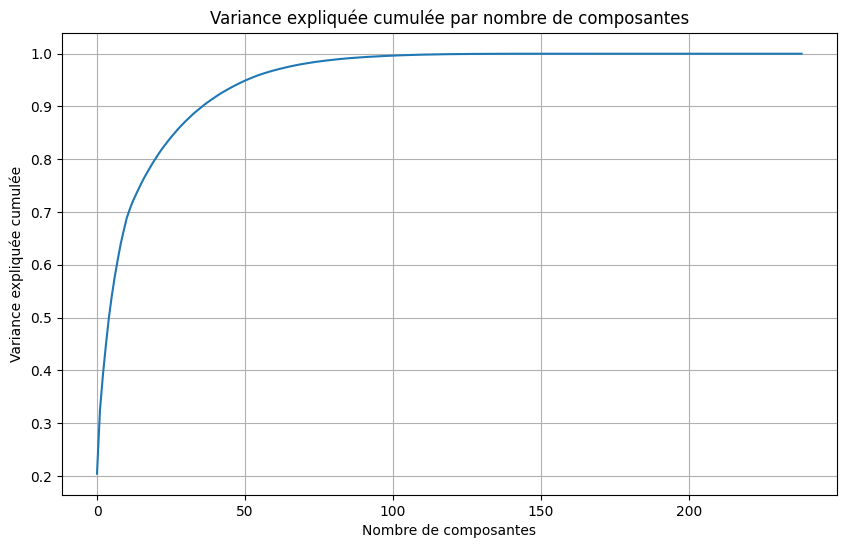

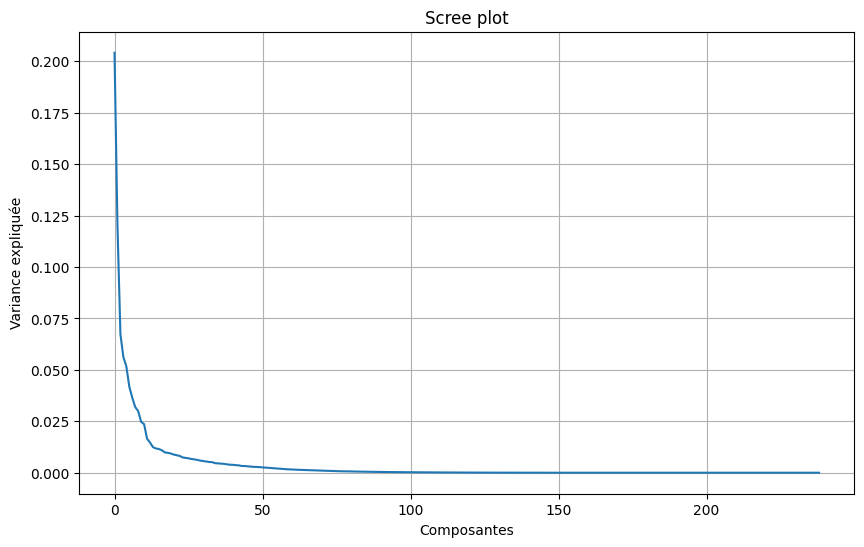

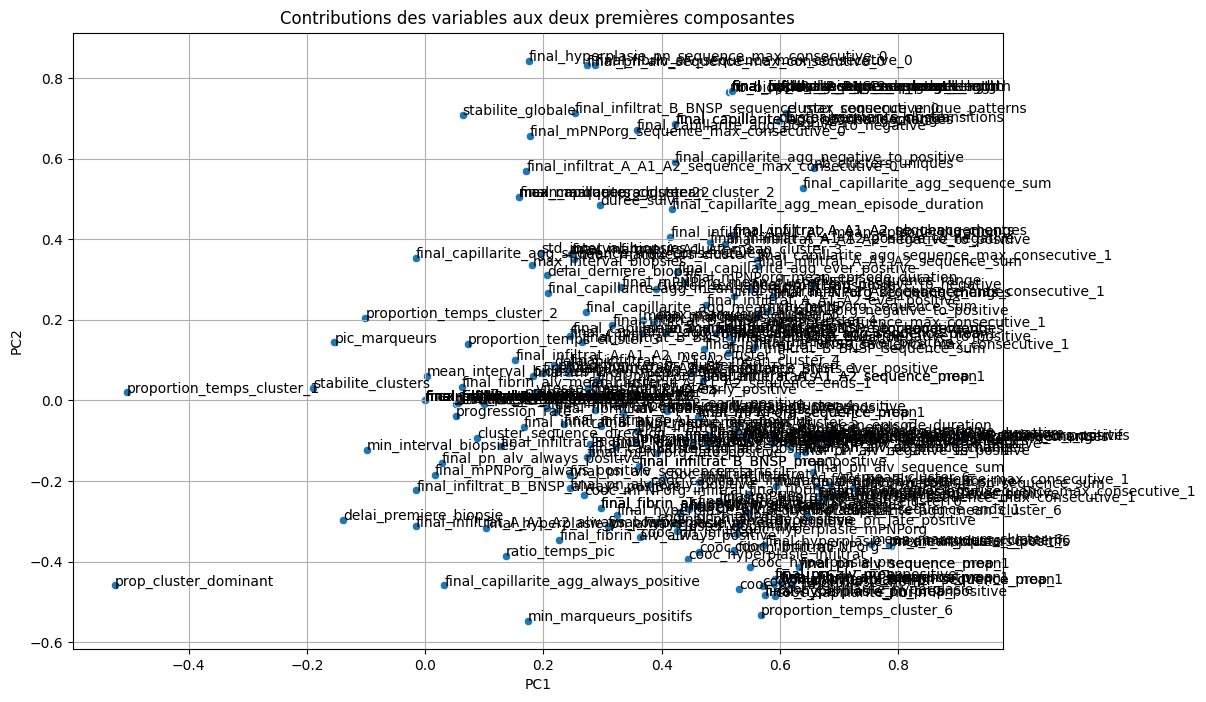


Top 10 contributeurs pour chaque composante principale:

PC1:
max_marqueurs_positifs                             0.905715
mean_marqueurs_positifs                            0.788682
max_marqueurs_cluster_6                            0.784631
mean_marqueurs_cluster_6                           0.754832
final_hyperplasie_pn_sequence_sum                  0.723213
final_hyperplasie_pn_sequence_max_consecutive_1    0.695702
final_hyperplasie_pn_negative_to_positive          0.685842
final_pn_alv_sequence_max_consecutive_1            0.685245
final_hyperplasie_pn_sequence_changes              0.680056
final_hyperplasie_pn_nb_changements                0.680056
Name: PC1, dtype: float64

PC2:
final_hyperplasie_pn_sequence_max_consecutive_0    0.843048
final_fibrin_alv_sequence_max_consecutive_0        0.833255
final_pn_alv_sequence_max_consecutive_0            0.831381
final_capillarite_agg_sequence_length              0.768322
final_infiltrat_A_A1_A2_sequence_length            0.768322
final

In [26]:
# 1. Préparation des données
# Suppression des colonnes non numériques et gestion des NaN
numeric_features = df_features.select_dtypes(include=["float64", "int64"]).columns
X = df_features[numeric_features].fillna(0)

# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Analyse des résultats
# Variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

# Plot de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée cumulée par nombre de composantes")
plt.grid(True)
plt.show()

# Plot du scree plot
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio)
plt.xlabel("Composantes")
plt.ylabel("Variance expliquée")
plt.title("Scree plot")
plt.grid(True)
plt.show()

# 5. Contributions des variables
n_comp = 10
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Création d'un DataFrame pour les loadings
loadings_df = pd.DataFrame(
    loadings[:, :n_comp],
    columns=[f"PC{i+1}" for i in range(n_comp)],
    index=numeric_features,
)

# Plot des contributions pour les deux premières composantes
plt.figure(figsize=(12, 8))
sns.scatterplot(data=loadings_df, x="PC1", y="PC2")
plt.title("Contributions des variables aux deux premières composantes")
plt.grid(True)

# Ajouter les labels des variables
for i, var in enumerate(numeric_features):
    plt.annotate(var, (loadings_df.iloc[i, 0], loadings_df.iloc[i, 1]))
plt.show()

# Affichage des top contributeurs pour chaque composante
print("\nTop 10 contributeurs pour chaque composante principale:")
for i in range(n_comp):
    print(f"\nPC{i+1}:")
    print(loadings_df[f"PC{i+1}"].abs().sort_values(ascending=False).head(10))

# 6. Création d'un DataFrame avec les composantes principales
pca_df = pd.DataFrame(
    X_pca[:, :n_comp],
    columns=[f"PC{i+1}" for i in range(n_comp)],
    index=df_features.index,
)

print("\nVariance expliquée par les premières composantes:")
for i, var in enumerate(explained_variance_ratio[:n_comp]):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")

In [25]:
# Création d'un DataFrame avec les composantes principales et l'identifiant patient
pca_df = pd.DataFrame(
    X_pca[:, :3],  # On prend les 3 premières composantes
    columns=["PC1", "PC2", "PC3"],
    index=df_features.index,
)

# Ajout de l'identifiant patient (NEFG2)
pca_df["NEFG2"] = df_features["NEFG2"]

# Réorganisation des colonnes pour avoir NEFG2 en premier
pca_df = pca_df[["NEFG2", "PC1", "PC2", "PC3"]]

# Affichage des premières lignes pour vérification
print("Aperçu du DataFrame des composantes principales :")
print(pca_df.head())

# Vérification de la forme
print("\nForme du DataFrame :", pca_df.shape)


# Sauvegarde si nécessaire
pca_df.to_csv("../data/analysis/pca_features.csv", index=False)

Aperçu du DataFrame des composantes principales :
      NEFG2       PC1       PC2       PC3
0    119222 -6.059952 -2.337604 -0.112934
1  119430#2 -4.147300  2.131158 -0.582274
2  129042#2 -1.878337  2.039656  4.220944
3    131960 -3.480378 -0.155022  1.850744
4  140937#2  0.614241  2.497368  7.819445

Forme du DataFrame : (498, 4)
